### Introduction

In this notebook, we explore classical **time series forecasting models** to predict stock prices, particularly the feature:  
**`Target_Close_Next_Day`** — the predicted closing price for the next day.

We'll implement and compare:

- **ARIMA** (AutoRegressive Integrated Moving Average)
- **SARIMA** (Seasonal ARIMA)
- **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity)

These models are statistically grounded and commonly used in financial forecasting due to their interpretability and robustness for short-term trend and volatility modeling.

---

### Why Statistical Models?

While machine learning models like Random Forest and XGBoost can capture nonlinear patterns, **time series models** are:

- Explicitly designed for time-ordered data
- Grounded in stochastic process theory
- Strong baselines for comparison with deep learning architectures

---

### Forecasting Target: `Target_Close_Next_Day`

Our goal is to forecast the closing price for the next trading day using these models, evaluate them using:

- **MAE (Mean Absolute Error)**
- **RMSE (Root Mean Squared Error)**
- **Residual Plots** for visual error analysis


### Load & Prepare Data for Time Series Modeling

We start from the `engineered_features.csv` file from the interim folder. For ARIMA/SARIMA/GARCH, we only need the time series of:
- `Date` (as index)
- `Target_Close_Next_Day` (forecast target)
- `Close/Last` (for plotting original trend)


In [43]:
# ADF Test and Plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os

# Load from interim features
interim_path = "../data/interim/engineered_features.csv"
processed_path = "../data/processed/processed_stock_data.csv"

df = pd.read_csv(interim_path, parse_dates=["Date"])
df = df.sort_values("Date")

# Filter only the required columns
df_processed = df[[
    "Date",
    "Close/Last",
    "Target_Close_Next_Day",
    "Daily_Return"  # for GARCH
]].copy()

df_processed.set_index("Date", inplace=True)
print(df_processed.head())

# Save to processed folder
os.makedirs("../data/processed", exist_ok=True)
df_processed.to_csv(processed_path)

print("Processed stock data saved to:", processed_path)

            Close/Last  Target_Close_Next_Day  Daily_Return
Date                                                       
2023-10-19      220.11                 211.99        -22.57
2023-10-20      211.99                 212.08         -8.12
2023-10-23      212.08                 216.52          0.09
2023-10-24      216.52                 212.42          4.44
2023-10-25      212.42                 205.76         -4.10
Processed stock data saved to: ../data/processed/processed_stock_data.csv


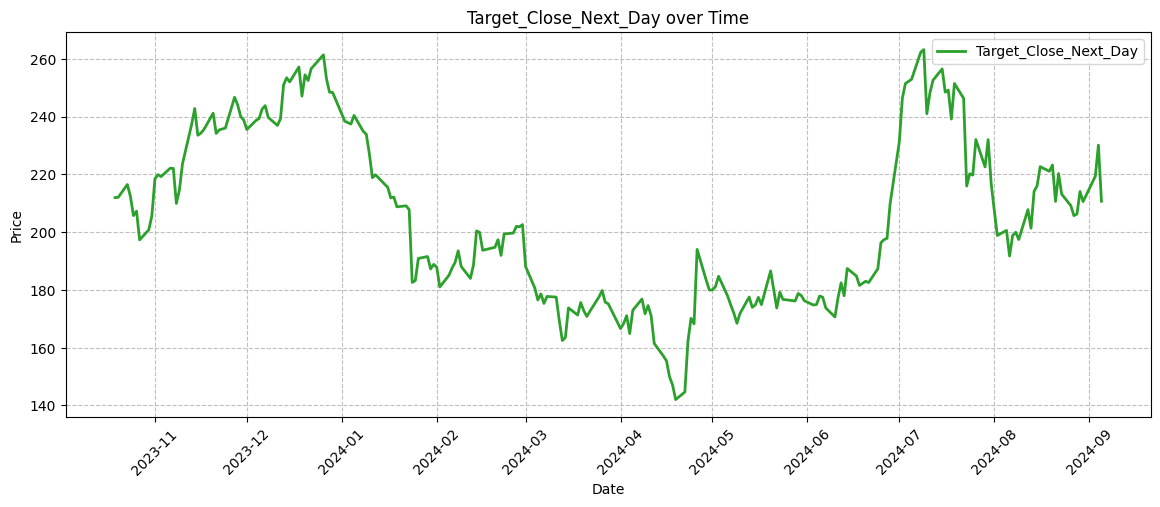

In [44]:
# Visual inspection
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Target_Close_Next_Day'], label='Target_Close_Next_Day',
         color='#2ca02c', linewidth=2)
plt.title("Target_Close_Next_Day over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.grid(True, linestyle='--', alpha=0.8)
plt.show()

### Stationarity in Time Series

Time series models like ARIMA require the data to be **stationary**, meaning the statistical properties (mean, variance, autocorrelation) do not change over time.

#### How to check for stationarity?

- **Visual Inspection**: Plotting the time series
- **ADF (Augmented Dickey-Fuller) Test**: A statistical test where:
  - **p-value < 0.05** ⇒ Reject null hypothesis ⇒ Data is stationary
  - **p-value > 0.05** ⇒ Cannot reject null ⇒ Data is non-stationary


In [45]:
# ADF Test
result = adfuller(df['Target_Close_Next_Day'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

if result[1] < 0.05:
    print("Series is stationary (reject null hypothesis).")
else:
    print("Series is non-stationary (cannot reject null hypothesis). Consider differencing.")

ADF Statistic: -1.8223799929384403
p-value: 0.36940861054616736
Critical Value (1%): -3.4604283689894815
Critical Value (5%): -2.874768966942149
Critical Value (10%): -2.57382076446281
Series is non-stationary (cannot reject null hypothesis). Consider differencing.


## ARIMA Model

### Theory

**ARIMA** stands for **AutoRegressive Integrated Moving Average** and is defined by three parameters:
- **p**: Number of autoregressive (AR) terms — lag observations in the model.
- **d**: Number of differences (I) needed to make the series stationary.
- **q**: Number of moving average (MA) terms — lagged forecast errors.

ARIMA assumes the time series is **stationary**. If not, we apply **differencing** (i.e., subtracting current value from previous) to remove trends.

---

We will:
1. Perform differencing if needed
2. Automatically find optimal (p, d, q) using `auto_arima`
3. Train the model
4. Forecast future values
5. Plot predictions vs actual
6. Evaluate performance


In [46]:
# !pip uninstall -y pmdarima
# !pip install numpy==1.24.4
# !pip install pmdarima --no-cache-dir

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load processed data
df = pd.read_csv("../data/processed/processed_stock_data.csv", parse_dates=["Date"], index_col="Date")

# Use Close/Last to predict Target_Close_Next_Day
ts = df["Target_Close_Next_Day"].dropna()

In [48]:
# ADF test to check stationarity
result = adfuller(ts)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Series is non-stationary, applying first-order differencing.")
    ts_diff = ts.diff().dropna()
else:
    print("Series is stationary.")
    ts_diff = ts

ADF Statistic: -1.8223799929384403
p-value: 0.36940861054616736
Series is non-stationary, applying first-order differencing.


In [49]:
# Use auto_arima to determine optimal parameters
stepwise_model = auto_arima(ts,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(f"\nBest ARIMA model: {stepwise_model.summary()}")

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1496.007, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1491.778, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1493.548, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1493.544, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1489.778, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1495.539, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.807 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Best ARIMA model:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -743.889
Date:                Tue, 13 May 2025   AIC                           1489.778
Time:                        15:31:59   BIC                           1493.171
Sample:                             0   HQIC                          1491.148
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        50.6403      3.222     15.718      0.000      44.326      56.955
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                59.73
Prob(Q):                    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


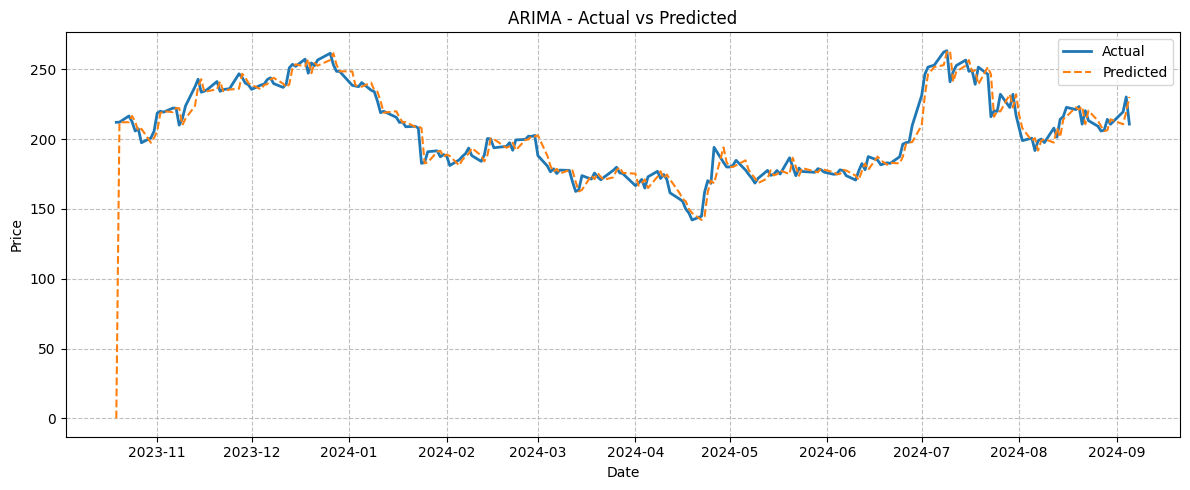

In [72]:
# Train ARIMA with best parameters
model = ARIMA(ts, order=stepwise_model.order)
model_fit = model.fit()

# Forecast
forecast = model_fit.predict(start=0, end=len(ts)-1)

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(ts, label="Actual", linewidth=2)
plt.plot(forecast, label="Predicted", linestyle='--')
plt.title("ARIMA - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

In [51]:
rmse_arima = np.sqrt(mean_squared_error(ts, forecast))
mae_arima = mean_absolute_error(ts, forecast)

print(f"Arima RMSE: {rmse_arima:.4f}")
print(f"Arima MAE : {mae_arima:.4f}")

Arima RMSE: 15.9298
Arima MAE : 6.1349


## SARIMA Model

### Theory: Why SARIMA?

- While ARIMA handles trend and autocorrelation, it doesn’t capture **seasonality**.
- **SARIMA (Seasonal ARIMA)** extends ARIMA by adding seasonal terms:
  - **(p, d, q)** × **(P, D, Q, s)**
  - `s` is the season length (e.g., 5 for weekly patterns in daily stock data)

---

### Implementation Steps:
1. Visualize for seasonality
2. Fit SARIMA model with selected order
3. Forecast & evaluate


In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit SARIMA Model
series = df_processed["Close/Last"]

# SARIMA(p,d,q)(P,D,Q,s)
sarima_model = SARIMAX(
    series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 5),  # Assuming 5-day weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        Close/Last   No. Observations:                  221
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -708.967
Date:                           Tue, 13 May 2025   AIC                           1427.934
Time:                                   15:32:00   BIC                           1444.621
Sample:                                        0   HQIC                          1434.681
                                           - 221                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3095      1.266      0.245      0.807      -2.172       2.791
ma.L1         -0.3220      1.264     -0.255

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


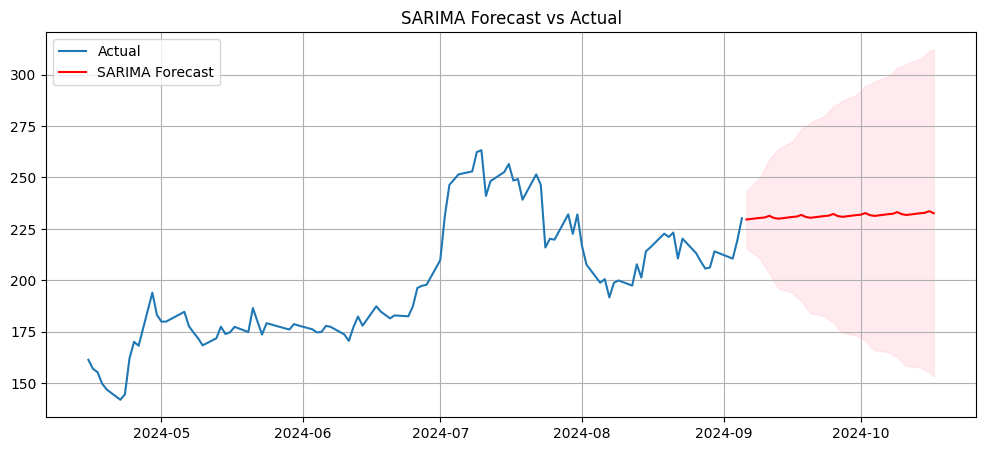

In [53]:
# Forecast using SARIMA
n_forecast = 30
sarima_forecast = sarima_result.get_forecast(steps=n_forecast)
sarima_pred = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(series[-100:], label="Actual")
plt.plot(pd.date_range(series.index[-1], periods=n_forecast+1, freq='B')[1:], sarima_pred, label="SARIMA Forecast", color="red")
plt.fill_between(pd.date_range(series.index[-1], periods=n_forecast+1, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Evaluation (on last 30 real values, if available)
true_values = df_processed["Target_Close_Next_Day"][-n_forecast:]

# Align predicted with true values
sarima_pred = sarima_pred[:len(true_values)]

mae_sarima = mean_absolute_error(true_values, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(true_values, sarima_pred))

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 19.21
SARIMA RMSE: 21.71


## GARCH Modeling
### Theory
- GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models the variance of the time series (i.e., volatility), not the price level itself.
- Volatility is often time-dependent, especially in financial data. GARCH captures this.
- Typically applied on returns (e.g., daily return or log return), not raw prices.

We use arch (Autoregressive Conditional Heteroskedasticity) library

In [55]:
!pip install arch

In [56]:
from arch import arch_model

# Use daily return for volatility modeling
returns = df_processed["Close/Last"].pct_change().dropna() * 100  # Percentage returns

# Fit GARCH(1,1) model
garch_model = arch_model(returns, vol='GARCH', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Close/Last   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -582.274
Distribution:                  Normal   AIC:                           1172.55
Method:            Maximum Likelihood   BIC:                           1186.12
                                        No. Observations:                  220
Date:                Tue, May 13 2025   Df Residuals:                      219
Time:                        15:32:03   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0294      0.226      0.130      0.897 [ -0.414,  0.47

In [57]:
# Forecast volatility for next 10 days
forecast = garch_fit.forecast(horizon=10)
volatility_forecast = np.sqrt(forecast.variance.values[-1, :])

print("Forecasted volatility (std dev) for next 10 days:")
print(volatility_forecast)

Forecasted volatility (std dev) for next 10 days:
[3.48780317 3.48368649 3.48019988 3.47724739 3.47474755 3.47263122
 3.47083975 3.4693234  3.46804001 3.46695386]


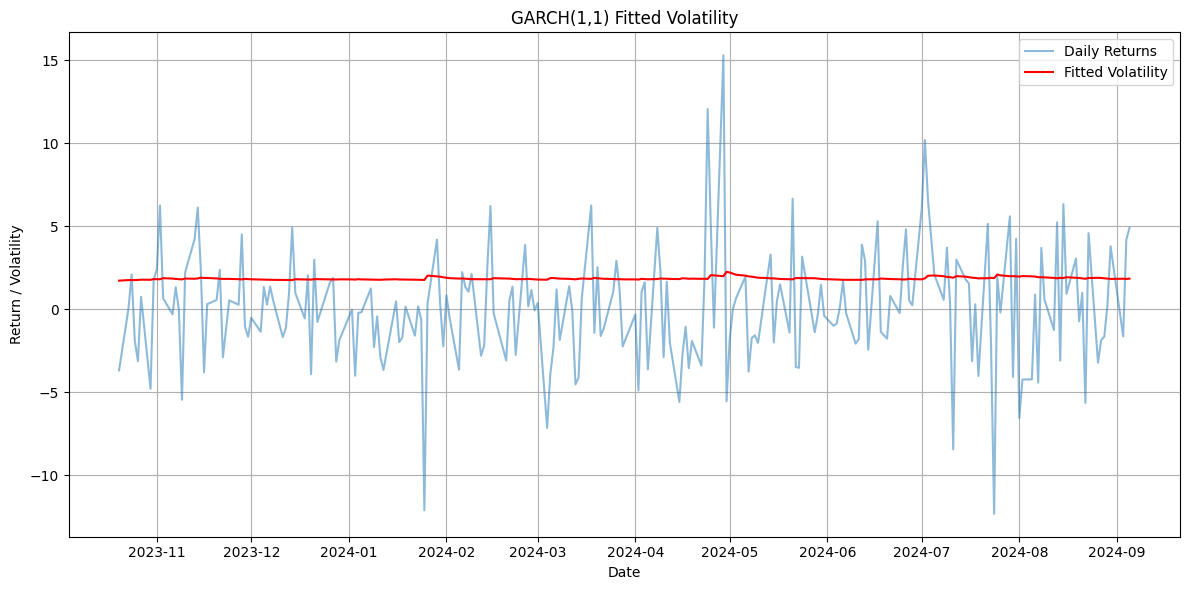

In [71]:
# In-sample fitted volatility
fitted_volatility = np.sqrt(garch_fit.conditional_volatility)

plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label="Daily Returns", alpha=0.5)
plt.plot(fitted_volatility.index, fitted_volatility, label="Fitted Volatility", color="red")
plt.title("GARCH(1,1) Fitted Volatility")
plt.xlabel("Date")
plt.ylabel("Return / Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation Summary
we compare the performance of all three models:
- ARIMA
- SARIMA
- GARCH (volatility forecast)

### Tabular Comparison (MAE, RMSE)
We only computed prediction errors (MAE, RMSE) for ARIMA and SARIMA, since GARCH models volatility, not price.

In [59]:
# ARIMA and SARIMA metrics (already computed previously)
summary_df = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA"],
    "MAE": [mae_arima, mae_sarima],
    "RMSE": [rmse_arima, rmse_sarima]
})

print(summary_df)

    Model        MAE       RMSE
0   ARIMA   6.134887  15.929801
1  SARIMA  19.205966  21.711764


<ipython-input-70-17c0fe2ced9a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Model", y="MAE", ax=axs[0], palette="Blues_d", legend=False)
<ipython-input-70-17c0fe2ced9a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Model", y="RMSE", ax=axs[1], palette="Greens_d", legend=False)


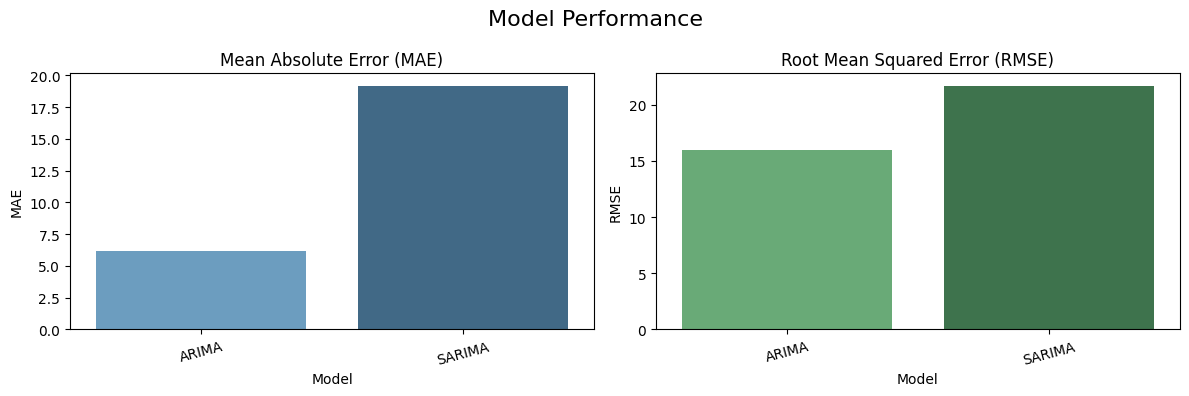

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=summary_df, x="Model", y="MAE", ax=axs[0], palette="Blues_d", legend=False)
axs[0].set_title("Mean Absolute Error (MAE)")
axs[0].tick_params(axis='x', rotation=15)

sns.barplot(data=summary_df, x="Model", y="RMSE", ax=axs[1], palette="Greens_d", legend=False)
axs[1].set_title("Root Mean Squared Error (RMSE)")
axs[1].tick_params(axis='x', rotation=15)

plt.suptitle("Model Performance", fontsize=16)
plt.tight_layout()
plt.show()